<a href="https://colab.research.google.com/github/tianyuanshao/MarchMadnessClassifier/blob/main/CBProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [44]:
# Import libraries 
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn as sk
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score

In [79]:
# Import datasets 

# ALL YEARS
cbb = pd.read_csv('/content/drive/MyDrive/CS271P/FinalProject/Datafiles/cbb.csv') 
cbb

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,Michigan St.,B10,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,19.2,36.1,27.6,36.6,32.4,50.4,44.3,34.1,30.1,64.4,6.7,S16,3.0,2013
2451,Arizona,P12,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,19.8,35.0,26.7,37.4,32.9,50.6,43.4,37.1,35.8,66.8,4.6,S16,6.0,2013
2452,Oregon,P12,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,22.0,35.8,27.2,38.4,33.3,49.1,44.9,33.3,33.4,69.2,2.9,S16,12.0,2013
2453,La Salle,A10,34,24,112.0,96.2,0.8516,51.9,49.3,17.1,21.3,29.0,34.2,31.3,28.5,49.3,50.6,37.7,30.2,66.0,0.3,S16,13.0,2013


In [80]:
# EDA: Basics
cbb.head(5)     # Obtain first 5 rows
len(cbb['CONF'].unique())    # Obtain distinct number of CONF variables (Athletic conference of school participation)
len(cbb.columns)    # Obtain total number of variables 
len(cbb.index)      # Obtain total number of rows
cbb.dtypes          # Types per columns
cbb.shape           # Dimensions of data frame

(2455, 24)

In [81]:
# Check for duplicate rows -CG
cbb_duplicated = cbb[cbb.duplicated()]
cbb_duplicated

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR


In [82]:
# EDA: Transforming Null Values/New Variable Assignments
cbb.isnull().sum()    # Obtain number of null values for each variable

# 1 = TRUE, 0 = FALSE
cbb['MAKE'] = np.where(pd.isnull(cbb.SEED), 0, 1)   # Create new bool variable MAKE for team making it into tournament 
cbb['CHAMP'] = np.where(cbb['POSTSEASON'] == 'Champions', 1, 0)   # Create new bool variable CHAMP for team winning Championship
cbb['FINALS'] = np.where(np.logical_or(cbb['POSTSEASON'] == 'Champions', cbb['POSTSEASON'] == '2ND')  , 1, 0)   # Create new bool variable FINAlS for teams making it to the finals
len(cbb.columns)

27

In [ ]:
# EDA: Transforming Wins Over Games Variables to Win Percentages
cbb.insert(2, 'WP', cbb.apply(lambda x:x['W']/x['G'], axis = 1))
cbb

In [ ]:
# EDA: Numerical Variables
cbbnum = cbb.drop(columns = ['YEAR', 'CONF', 'POSTSEASON', 'SEED', 'MAKE', 'CHAMP', 'FINALS'])  # Include only columns with numerical values
cbbnum.describe()       # Summary statistics for numerical variables 
#cbbnum.G.hist()
#cbbnum.W.hist()
#cbbnum.ADJOE.hist()
#cbbnum.ADJDE.hist()
#cbbnum.BARTHAG.hist()
#cbbnum.EFG_O.hist()
#cbbnum.EFG_D.hist()
#cbbnum.TOR.hist()
#cbbnum.TORD.hist()
#cbbnum.ORB.hist()
#cbbnum.DRB.hist()
#cbbnum.FTR.hist()
#cbbnum.FTRD.hist()
#cbbnum.2P_O.hist()
#cbbnum.2P_D.hist()
#cbbnum.3P_O.hist()
#cbbnum.3P_D.hist()
#cbbnum.ADJ_T.hist()
#cbbnum.WAB.hist()

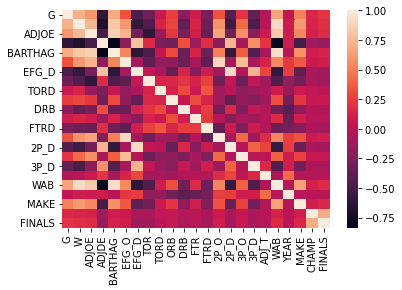

In [ ]:
# EDA: Heatmap
cbbnew = cbb.drop(columns = ['SEED', 'POSTSEASON'])     # Drop columns with null values (already transformed)
len(cbbnew.columns)
cbbnew.isnull().sum()     # Check for null values

# Can customize correlation method (Pearson by default): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html -CG
sb.heatmap(cbbnew.corr())    # Plot heatmap for database

In [ ]:
# Detect Outliers by IQR
Q1 = cbbnew.quantile(.25)
Q3 = cbbnew.quantile(.75)
IQR = Q3 - Q1

outliers = cbbnew[((cbbnew < (Q1 - (IQR * 3))) |(cbbnew > (Q3 + (IQR * 3)))).any(axis=1)]
outliers.shape

(479, 25)

In [ ]:
# Boxplots

# sb.boxplot(x=cbbnew['W'])
# sb.boxplot(x=cbbnew['ADJOE'])
# sb.boxplot(x=cbbnew['ADJDE'])
# sb.boxplot(x=cbbnew['BARTHAG'])
# sb.boxplot(x=cbbnew['EFG_O'])
# sb.boxplot(x=cbbnew['EFG_D'])
# sb.boxplot(x=cbbnew['TOR'])
# sb.boxplot(x=cbbnew['TORD'])
# sb.boxplot(x=cbbnew['ORB'])
# sb.boxplot(x=cbbnew['DRB'])
# sb.boxplot(x=cbbnew['FTR'])
# sb.boxplot(x=cbbnew['FTRD'])
# sb.boxplot(x=cbbnew['2P_O'])
# sb.boxplot(x=cbbnew['2P_D'])
# sb.boxplot(x=cbbnew['3P_O'])
# sb.boxplot(x=cbbnew['3P_D'])
# sb.boxplot(x=cbbnew['ADJ_T'])
# sb.boxplot(x=cbbnew['WAB']) 

In [ ]:
# EDA: Mean Statistics for Teams
cbbnew.groupby('TEAM').mean()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,YEAR,MAKE,CHAMP,FINALS
TEAM,,,,,,,,,,,,,,,,,,,,,,,
Abilene Christian,26.500000,12.333333,96.150000,109.050000,0.220150,49.966667,53.383333,19.983333,20.716667,25.133333,30.866667,35.183333,44.216667,47.466667,53.400000,36.333333,35.600000,66.883333,-11.950000,2016.5,0.166667,0.0,0.0
Air Force,29.714286,12.571429,101.971429,106.057143,0.390086,50.642857,52.957143,19.000000,18.914286,25.871429,28.600000,33.714286,35.385714,50.042857,52.485714,34.400000,35.657143,66.071429,-10.200000,2016.0,0.000000,0.0,0.0
Akron,33.000000,21.285714,104.671429,99.928571,0.627429,51.171429,47.928571,18.457143,18.500000,30.814286,30.128571,33.657143,35.300000,49.971429,47.185714,34.928571,33.128571,66.914286,-4.971429,2016.0,0.142857,0.0,0.0
Alabama,33.714286,18.142857,106.585714,94.985714,0.789186,49.714286,47.071429,19.571429,19.200000,30.700000,31.357143,40.185714,36.942857,49.871429,46.271429,32.957143,32.414286,65.785714,-1.857143,2016.0,0.142857,0.0,0.0
Alabama A&M,29.285714,7.000000,91.014286,113.071429,0.090200,45.214286,51.057143,20.942857,17.785714,30.500000,33.571429,36.342857,39.100000,45.528571,50.757143,29.728571,34.528571,65.985714,-18.428571,2016.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wright St.,32.428571,19.428571,100.514286,98.914286,0.546800,50.500000,49.800000,18.914286,21.271429,25.871429,27.442857,35.557143,39.085714,48.928571,49.128571,35.471429,33.971429,66.400000,-7.242857,2016.0,0.142857,0.0,0.0
Wyoming,32.142857,17.142857,102.600000,101.585714,0.535014,51.514286,48.628571,18.085714,17.771429,20.000000,28.942857,41.357143,34.785714,51.357143,47.442857,34.328571,33.885714,66.514286,-7.171429,2016.0,0.142857,0.0,0.0
Xavier,34.857143,23.000000,113.814286,96.842857,0.852571,52.442857,49.442857,18.542857,17.571429,33.114286,26.685714,39.700000,31.942857,52.400000,48.814286,35.142857,33.628571,67.671429,1.985714,2016.0,0.714286,0.0,0.0


In [90]:
# EDA: Creating Training Data
y = cbb['MAKE']         # Set target value to FINALS
cbb['MAKE'].value_counts()
x = cbb.drop(columns = ['MAKE', 'CHAMP', 'FINALS', 'POSTSEASON', 'SEED'], axis = 1)

# Try dropping games played/won/won above bubble -- possible overfitting
#x.drop(columns=['G', 'W', 'WAB', 'BARTHAG'],inplace=True)
x.drop(columns=['G','W','WAB', 'BARTHAG', 'ADJOE', 'ADJDE', 'ADJ_T'],inplace=True)

In [ ]:
# EDA: Transforming the TEAM and CONF Variables 
# Create dictionary for team indexes
x_team_unique = x.TEAM.unique()
team_index = list(range(1, len(x_team_unique)+1))
team_dictionary = dict(zip(x_team_unique,team_index))

# Insert column for TEAM ID's -- need this, as changing existing column values to ID would probably still result in string
x.insert(0,'TEAMID',0)

# Change TEAMID in dataset to indexes
for i in range(len(x['TEAM'])):
  x['TEAMID'][i] = team_dictionary[x['TEAM'][i]]

# Create dictionary for conferences
x_conf_unique = x.CONF.unique()
conference_index = list(range(1, len(x_conf_unique)+1))
conference_dictionary = dict(zip(x_conf_unique,conference_index))

# Insert column for CONF ID's -- need this, as changing existing column values to ID would probably still result in string
x.insert(1,'CONFID',0)

# Change CONFID in dataset to indexes
for i in range(len(x['CONF'])):
  x['CONFID'][i] = conference_dictionary[x['CONF'][i]]

# Drop non-numerical columns
x.drop(columns = ['TEAM', 'CONF'], inplace=True)

# There is a warning for setting on a copy of a DataFrame slice. Let me know if we need to fix this
print(x['TEAMID'])
print(x['CONFID'])


In [101]:
# Splitting into Test/Train Data
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x,y, test_size = 0.20)

# Splitting into Train/Validation Data
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(x_train, y_train, test_size = 0.125)

In [ ]:
# Logistic Regression

In [105]:
# XGBoost
# https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py


xg_class = xgb.XGBClassifier(n_estimators = 20)
xg_class.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], 
            early_stopping_rounds=4)


preds = xg_class.predict(x_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-error:0.097206	validation_1-error:0.113821
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 4 rounds.
[1]	validation_0-error:0.091385	validation_1-error:0.093496
[2]	validation_0-error:0.091385	validation_1-error:0.093496
[3]	validation_0-error:0.091385	validation_1-error:0.093496
[4]	validation_0-error:0.091385	validation_1-error:0.093496
[5]	validation_0-error:0.091385	validation_1-error:0.093496
Stopping. Best iteration:
[1]	validation_0-error:0.091385	validation_1-error:0.093496

Accuracy: 89.61%


In [100]:
#xg_class.get_score(importance_type='gain')
print(xg_class.feature_importances_)



[0.22994713 0.23442264 0.41934487 0.         0.         0.
 0.         0.         0.         0.03545135 0.         0.04810814
 0.         0.0327258  0.         0.        ]


In [89]:
x

,TEAMID,CONFID,WP,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,YEAR
0,1,1,0.825000,123.3,94.9,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,2016
1,2,2,0.900000,129.1,93.6,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,2015
2,3,2,0.825000,114.4,90.4,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,2018
3,4,3,0.815789,115.2,85.2,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,2019
4,5,4,0.948718,117.8,86.3,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,21,2,0.742857,111.4,87.8,50.6,44.5,20.8,19.2,36.1,27.6,36.6,32.4,50.4,44.3,34.1,30.1,64.4,2013
2451,18,8,0.771429,114.4,92.2,52.5,46.6,19.5,19.8,35.0,26.7,37.4,32.9,50.6,43.4,37.1,35.8,66.8,2013
2452,19,8,0.756757,104.8,88.6,49.3,46.4,21.4,22.0,35.8,27.2,38.4,33.3,49.1,44.9,33.3,33.4,69.2,2013
2453,35,9,0.705882,112.0,96.2,51.9,49.3,17.1,21.3,29.0,34.2,31.3,28.5,49.3,50.6,37.7,30.2,66.0,2013


In [ ]:
results = xg_class.evals_result()
results
rmse = np.sqrt(MSE())
plt.figure(figsize = (10,7))
plt.plot(results["validation_0"]["rmse"], label = "Training loss")
plt.plot(results["validation_1"]["rmse"], label = "Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

NameError: ignored

In [ ]:
results

{'validation_0': {'error': [0.00291, 0.00291, 0.002328, 0.002328]},
 'validation_1': {'error': [0.004065, 0.004065, 0.004065, 0.004065]}}

In [46]:
# Confusion Matrix
skm.confusion_matrix(y_test, preds)

array([[487,   0],
       [  4,   0]])